In [27]:
# Python imports
import os
import math

# PyTorch imports
import torch
import torchvision

# Third-party imports
import matplotlib.pyplot as plt
from tabulate import tabulate

# 0. Constants

In [28]:
BATCH_SIZE = 10
LEARNING_RATE = 0.1
EPOCHS = 10
WIDTH, HEIGHT = 28, 28
SAVED_FILENAME = 'MNIST-1-2'
LAYER_SIZES = [16, 32, 64, 128, 256]

# 1. Dataset

In [29]:
# Load datasets.
dataset_training = torchvision.datasets.MNIST('./data', download=True, train=True, transform=torchvision.transforms.ToTensor())
dataset_test = torchvision.datasets.MNIST('./data', download=True, train=False, transform=torchvision.transforms.ToTensor())

# Create data loaders.
dataloader_training = torch.utils.data.DataLoader(dataset_training, batch_size=BATCH_SIZE, shuffle=True)
dataloader_test = torch.utils.data.DataLoader(dataset_test, batch_size=BATCH_SIZE, shuffle=True)

# 2. Models

In [30]:
# Create a model for each learning rate.
models = []
for i in range(len(LAYER_SIZES)):
    models.append(torch.nn.Sequential(
        torch.nn.Flatten(),
        torch.nn.Linear(WIDTH*HEIGHT, LAYER_SIZES[i]),
        torch.nn.Linear(LAYER_SIZES[i], 10),
        torch.nn.Softmax(dim=1)
    ))

## 2.1. Statistics of the Models

In [31]:
nums_parameters = []
for i in range(len(LAYER_SIZES)):
    num_parameters = 0
    for params in models[i].parameters():
        num_parameters_temp = 1
        size = params.size()
        for dim_size in size:
            num_parameters_temp *= dim_size
        num_parameters += num_parameters_temp
    nums_parameters.append(num_parameters)

headers = ['Layer Size', 'Number of Parameters']

rows = []
for i in range(len(LAYER_SIZES)):
    rows.append([LAYER_SIZES[i], nums_parameters[i]])

print(tabulate(rows, headers=headers, tablefmt='github'))

|   Layer Size |   Number of Parameters |
|--------------|------------------------|
|           16 |                  12730 |
|           32 |                  25450 |
|           64 |                  50890 |
|          128 |                 101770 |
|          256 |                 203530 |


# 3. Training

## 3.1. Helper Functions

In [32]:
def calculateStatistics(dataloader, model, loss_fn):
    with torch.no_grad():
        num_batches = len(dataloader)
        num_samples = len(dataloader.dataset)
        loss, correct = 0, 0

        for images, labels in dataloader:
            # Make predictions.
            preds = model(images)

            # Calculate the loss.
            loss += loss_fn(preds, labels)

            # Calculate the number of correctnesses.
            correct += (preds.argmax(dim=1) == labels).type(dtype=torch.float32).sum()

        # Calculate the mean loss and correct.
        loss /= num_batches
        correct /= num_samples

    return loss, correct

## 3.2. Training

In [33]:
def load(models):
    # Retrieve saved data.
    data = torch.load(f'saved/{SAVED_FILENAME}.pt')

    # Construct structs losses, corrects, losses_test and corrects_test for returning.
    losses, corrects, losses_test, corrects_test = [], [], [], []

    # Resume model from saved data.
    for i in range(len(LAYER_SIZES)):
        state_dict = data[i]['state_dict']
        models[i].load_state_dict(state_dict)
        losses.append(data[i]['losses'])
        corrects.append(data[i]['corrects'])
        losses_test.append(data[i]['losses_test'])
        corrects_test.append(data[i]['corrects_test'])

    # Return losses and accuracies for training and testing.
    return losses, corrects, losses_test, corrects_test

def save(models, losses, corrects, losses_test, corrects_test):
    # Create folder 'saved' if it does not exist.
    if not os.path.exists('saved'):
        os.makedirs('saved')

    # Construct the struct of data to save.
    data = []
    for i in range(len(LAYER_SIZES)):
        data.append({
            'state_dict': models[i].state_dict(),
            'losses': losses[i],
            'corrects': corrects[i],
            'losses_test': losses_test[i],
            'corrects_test': corrects_test[i],
        })

    # Save data to the file.
    torch.save(data, f'saved/{SAVED_FILENAME}.pt')

def train(model, epochs, learning_rate):
    loss_fn = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), learning_rate)

    # Define losses and corrects for training and test.
    losses, corrects = [], []
    losses_test, corrects_test = [], []

    # Calculate losses and corrects before training.
    loss, correct = calculateStatistics(dataloader_training, model, loss_fn)
    losses.append(loss)
    corrects.append(correct)
    loss_test, correct_test = calculateStatistics(dataloader_test, model, loss_fn)
    losses_test.append(loss)
    corrects_test.append(correct_test)

    # Run epochs.
    for epoch in range(epochs):

        # Run one epoch for training.
        num_batches = len(dataloader_training)
        num_samples = len(dataloader_training.dataset)
        loss_epoch, correct_epoch = 0, 0
        for batch, [images, labels] in enumerate(dataloader_training):
            # Make predictions.
            pred = model(images)

            # Calculate the loss.
            loss = loss_fn(pred, labels)
            loss_epoch += loss.item()

            # Calculate the number of correctness.
            correct_epoch += (pred.argmax(dim=1) == labels).type(dtype=torch.float32).sum().item()

            # Calculate gradients.
            optimizer.zero_grad()
            loss.backward()

            # Optimization.
            optimizer.step()

            if (batch + 1) % 1000 == 0:
                loss = loss.item()
            
        # Calculate the mean loss across all batches.
        loss_epoch /= num_batches
        losses.append(loss_epoch)

        # Calculate the mean number of correctness across all batches.
        correct_epoch /= num_samples
        corrects.append(correct_epoch)

        # Calculate loss and correct for test.
        loss_test, correct_test = calculateStatistics(dataloader_test, model, loss_fn)
        losses_test.append(loss_test)
        corrects_test.append(correct_test)

    # Return losses and accuracies for training and testing.
    return losses, corrects, losses_test, corrects_test

In [34]:
if os.path.exists(f'saved/{SAVED_FILENAME}.pt'):
    losses, corrects, losses_test, corrects_test = load(models)
else:
    losses, corrects, losses_test, corrects_test = [], [], [], []
    for i in range(len(LAYER_SIZES)):
        print(f'Training the model for layer size {LAYER_SIZES[i]}...')
        losses_1_model, corrects_1_model, losses_test_1_model, corrects_test_1_model = train(models[i], EPOCHS, LEARNING_RATE)
        losses.append(losses_1_model)
        corrects.append(corrects_1_model)
        losses_test.append(losses_test_1_model)
        corrects_test.append(corrects_test_1_model)
    save(models, losses, corrects, losses_test, corrects_test)

Training the model for layer size 16...
Training the model for layer size 32...
Training the model for layer size 64...
Training the model for layer size 128...
Training the model for layer size 256...


## 3.3. Visualization of the Training Process

### 3.3.1. Visualization of Losses and Accuracies

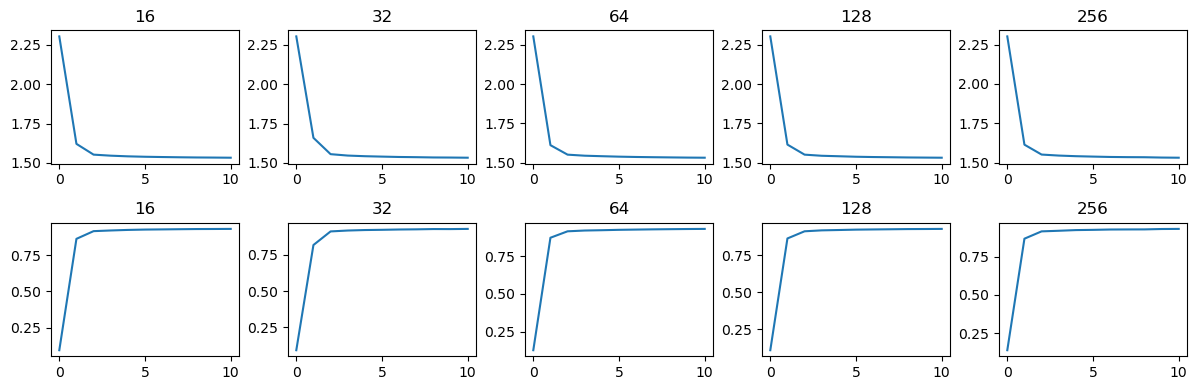

In [35]:
fig, axs = plt.subplots(2, len(LAYER_SIZES), figsize=(12, 4))
for i in range(len(LAYER_SIZES)):
    axs[0, i].plot(losses[i])
    axs[0, i].set_title(f'{LAYER_SIZES[i]}')
    axs[1, i].plot(corrects[i])
    axs[1, i].set_title(f'{LAYER_SIZES[i]}')
plt.tight_layout()